In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale
from matplotlib import pyplot as plt
import scipy.stats as stats
import time

In [2]:
# Load dataframe from nasdaq csv
df = pd.read_csv('nasdaq_screener_1682697438506.csv')

# Drop rows where important columns are NaN
df.dropna(subset=['Symbol'], inplace=True)
df.dropna(subset=['Market Cap'], inplace=True)
df.dropna(subset=['Industry'], inplace=True)

# Drop columns that are not important and have lots of NaNs
df.drop('IPO Year', axis=1, inplace=True)
df.drop('Last Sale', axis=1, inplace=True)  # Not important as sale price is arbitrary, mkt cap is what matters
df.drop('Net Change', axis=1, inplace=True) # Not important as it is relative to "Last Sale column"

# Change data to preferred type
df['% Change'] = pd.to_numeric(df['% Change'].str.replace('%', '')) # Delete % signs in column, to change to float

# Reset index for ease
df = df.reset_index(drop=True)

     Symbol                                               Name Last Sale  \
0         A             Agilent Technologies Inc. Common Stock   $135.89   
1        AA                    Alcoa Corporation Common Stock     $36.74   
2       AAC  Ares Acquisition Corporation Class A Ordinary ...    $10.38   
3      AACG   ATA Creativity Global American Depositary Shares     $1.80   
4     AACIW                 Armada Acquisition Corp. I Warrant   $0.0978   
...     ...                                                ...       ...   
7631   ZVSA             ZyVersa Therapeutics Inc. Common Stock    $0.447   
7632    ZWS  Zurn Elkay Water Solutions Corporation Common ...    $21.52   
7633   ZYME                        Zymeworks Inc. Common Stock     $8.26   
7634   ZYNE          Zynerba Pharmaceuticals Inc. Common Stock    $0.398   
7635   ZYXI                            Zynex Inc. Common Stock    $11.27   

      Net Change  % Change    Market Cap        Country  IPO Year   Volume  \
0        

In [3]:
# Load data from other csv here
# Data is not directly queried from API as doing so would take ~2 days on my PC. Computation was split into a regular .py file so multithreading was possible and run on a 32 core gcp instance.
df_detailed = pd.read_csv('results.csv')
df2 = pd.read_csv('results_for_real.csv')
df3 = pd.merge(df, df2, on="Symbol", how="inner").drop_duplicates(subset="Symbol", keep="last").reset_index(drop=True)
print(df3.columns)
df_num = df3.loc[:, ['% Change','Market Cap', 'Volume', 'beta', 'dy', 'pe', 'roe']]

# Normalize the data to be between -1 and 1 so that market cap doesn't dominate the results
df_num = pd.DataFrame(np.sign(df_num) * minmax_scale(np.abs(df_num)))
print(df_num)

Index(['Symbol', 'Name', '% Change', 'Market Cap', 'Country', 'Volume',
       'Sector', 'Industry', 'beta', 'dy', 'pe', 'roe'],
      dtype='object')
      % Change  Market Cap    Volume      beta        dy        pe       roe
0     0.045927    0.013753  0.005050  0.665728  0.013145  0.005660  0.003941
1     0.030046    0.002242  0.011926  0.215161  0.021908  0.002879 -0.001906
2     0.000000    0.000019  0.000036  0.002044       NaN -0.000393 -0.004659
3    -0.078245    0.000064  0.000242  0.046221       NaN -0.000794 -0.006584
4    -0.020796    0.000024  0.000160  0.206738       NaN  0.001958  0.000391
...        ...         ...       ...       ...       ...       ...       ...
2065  0.074512    0.017572  0.007721  0.274779  0.243378  0.002445       NaN
2066  0.000000    0.000027  0.000374  0.148840       NaN -0.001683 -0.003406
2067  0.000046    0.000019  0.000163  0.027845       NaN  0.001355  0.003895
2068  0.044327    0.029089  0.033173  0.374600       NaN  0.003567  0.001845
20

In [4]:
def distance(x,y):
    return np.sqrt(np.sum((x-y)**2))

def kmeans(df, k=4, tol=0.01, seed=1337): 
    np.random.seed(seed)
    clocs=np.random.choice(range(len(df)), size=k)
    centroids = np.array([df.iloc[clocs[ki]] for ki in range(k)])# random centroids from data
    
    # Initialize objects for points-cluster dists, cluster assignments.
    dists=np.zeros((k,len(df)))
    clusters = np.array([-1]*len(df))
    
    # index/convergence trackers
    i=0
    Done=False
    while not Done: # 50+ steps is enough to terminate, longer will take too much time. Tolerance check is faster for all my tests.
        # convergence checks
        centroidso=centroids.copy()
        i+=1
        if i==50: 
            Done=True
            print('No convergence in 50 steps')

        for j in range(k): #for j'th cluster, compute its distance to all points.
            dists[j,:]=df.apply(lambda x: distance(x, centroids[j]), axis=1)

        clusters=dists.argmin(axis=0)
        
        for j in range(k):
            centroids[j,:]=np.sum(df.loc[clusters==j])/np.sum(clusters==j)
            
        if distance(centroids, centroidso)<tol: 
            print('Done at iteration',i, 'with change of', distance(centroids, centroidso))
            Done=True
    meanerror=np.sum(dists.min(axis=0)**2)/len(df) #we already had the info needed saved!
    return centroids, clusters, meanerror

In [5]:
kvals=range(1,10)
nruns=3
meanerrors=np.zeros((nruns, len(kvals)))
clusters_arr=[0] * len(kvals)
centroids_arr=[0] * len(kvals)
i = 0
for kval in kvals:
    print(f"kval: {kval}")
    start = time.time()
    for ri in range(nruns):
        centroids_arr[kval - 1], clusters_arr[kval - 1], meanerrors[ri, kval-1] =  kmeans(df_num, k=kval, seed=ri+i)
    end = time.time()
    print(f"3 trials at k = {kval} took {round((end - start),2)} seconds")
    print('------------------------------------------------------------')
    i += 1

kval: 1
Done at iteration 2 with change of 0.0
Done at iteration 2 with change of 0.0
Done at iteration 2 with change of 0.0
3 trials at k = 1 took 2.48 seconds
------------------------------------------------------------
kval: 2
Done at iteration 2 with change of 0.006709173689592531
Done at iteration 3 with change of 0.006433923106868374
Done at iteration 6 with change of 0.006287753473330069
3 trials at k = 2 took 8.78 seconds
------------------------------------------------------------
kval: 3
Done at iteration 6 with change of 0.009357443958349613
Done at iteration 13 with change of 0.009142033115552119
Done at iteration 4 with change of 0.005811546065124923
3 trials at k = 3 took 26.99 seconds
------------------------------------------------------------
kval: 4
Done at iteration 10 with change of 0.00920281509368853
Done at iteration 5 with change of 0.006198010672893181
Done at iteration 6 with change of 0.009567696223121211
3 trials at k = 4 took 33.15 seconds
-----------------

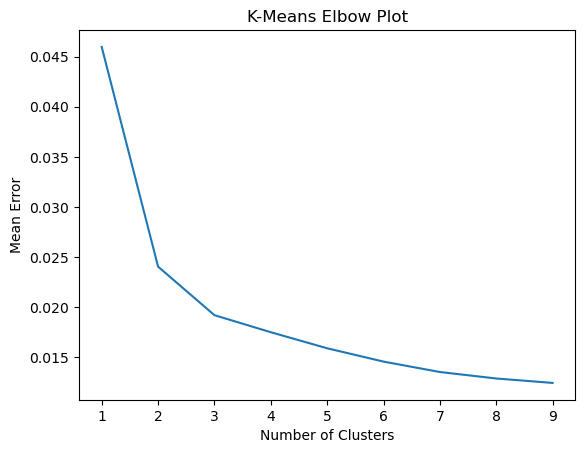

In [6]:
besterrors=np.min(meanerrors,0)
plt.title('K-Means Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Error')
plt.plot(range(1,10), besterrors)

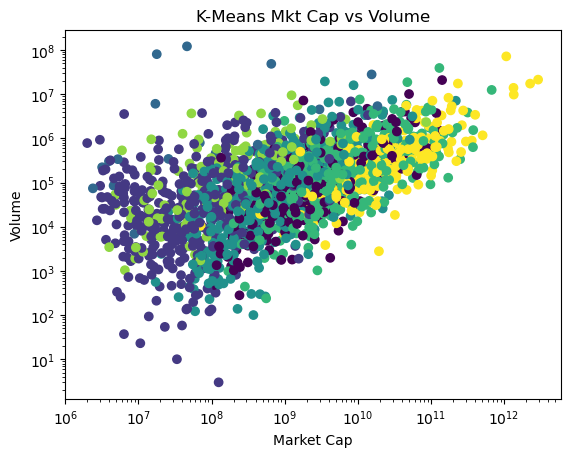

In [48]:
clusters = clusters_arr[6]
plt.xlabel('Market Cap')
plt.ylabel('Volume')
plt.title('K-Means Mkt Cap vs Volume')
plt.xscale("log")
plt.yscale("log")
plt.scatter(df3['Market Cap'], df3['Volume'], c=clusters)

In cluster 0, 100% of companies had a mkt cap over 100 million, 65% of companies had a mkt cap over 1 billion, 15% of companies had a mkt cap over 10 billion, 1% of companies had a mkt cap over 100 billion
In cluster 1, 36% of companies had a mkt cap over 100 million, 8% of companies had a mkt cap over 1 billion, 0% of companies had a mkt cap over 10 billion, 0% of companies had a mkt cap over 100 billion
In cluster 2, 38% of companies had a mkt cap over 100 million, 22% of companies had a mkt cap over 1 billion, 11% of companies had a mkt cap over 10 billion, 0% of companies had a mkt cap over 100 billion
In cluster 3, 90% of companies had a mkt cap over 100 million, 43% of companies had a mkt cap over 1 billion, 5% of companies had a mkt cap over 10 billion, 0% of companies had a mkt cap over 100 billion
In cluster 4, 100% of companies had a mkt cap over 100 million, 84% of companies had a mkt cap over 1 billion, 32% of companies had a mkt cap over 10 billion, 4% of companies had a m

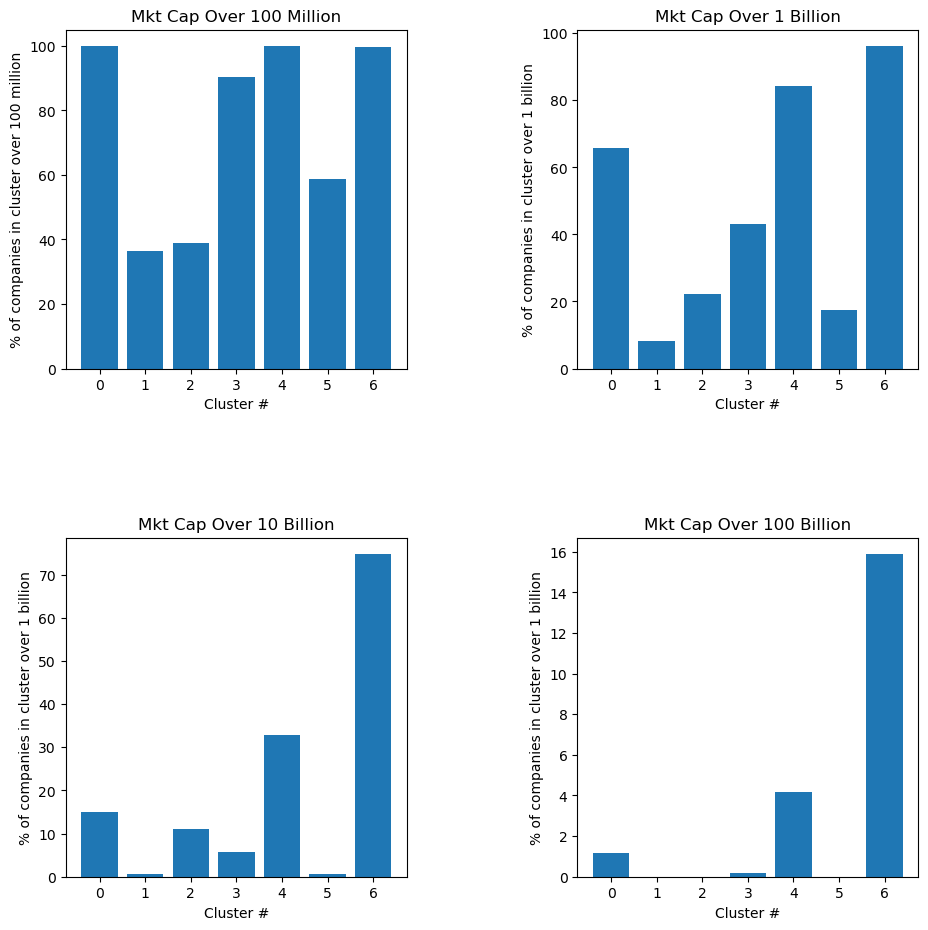

In [8]:
over_100_mil = [0] * len(set(clusters)) # 10 ** 8
over_1_bil = [0] * len(set(clusters))   # 10 ** 9
over_10_bil = [0] * len(set(clusters))  # 10 ** 10
over_100_bil = [0] * len(set(clusters)) # 10 ** 11
num_each_clust = [0] * len(set(clusters))
for idx, row in df3.iterrows():
    num_each_clust[clusters[idx]] += 1
    if row['Market Cap'] > 10 ** 8:
        over_100_mil[clusters[idx]] += 1
    if row['Market Cap'] > 10 ** 9:
        over_1_bil[clusters[idx]] += 1
    if row['Market Cap'] > 10 ** 10:
        over_10_bil[clusters[idx]] += 1
    if row['Market Cap'] > 10 ** 11:
        over_100_bil[clusters[idx]] += 1
over_100_mil_percent = (np.array(over_100_mil) / np.array(num_each_clust)) * 100
over_1_bil_percent = (np.array(over_1_bil) / np.array(num_each_clust)) * 100
over_10_bil_percent = (np.array(over_10_bil) / np.array(num_each_clust)) * 100
over_100_bil_percent = (np.array(over_100_bil) / np.array(num_each_clust)) * 100
for i in range(len(set(clusters))):
    print(f"In cluster {i}, {int(over_100_mil_percent[i])}% of companies had a mkt cap over 100 million, {int(over_1_bil_percent[i])}% of companies had a mkt cap over 1 billion, {int(over_10_bil_percent[i])}% of companies had a mkt cap over 10 billion, {int(over_100_bil_percent[i])}% of companies had a mkt cap over 100 billion")

# Define the labels for the x-axis
labels = [i for i in range(len(set(clusters)))]

# Create a figure and four subplots
fig, axes = plt.subplots(2, 2,  figsize=(11, 11))

# Plot each list as a bar graph on a subplot
axes[0, 0].bar(labels, over_100_mil_percent)
axes[0, 1].bar(labels, over_1_bil_percent)
axes[1, 0].bar(labels, over_10_bil_percent)
axes[1, 1].bar(labels, over_100_bil_percent)

# Add axis labels and titles to each subplot
axes[0, 0].set_ylabel("% of companies in cluster over 100 million")
axes[0, 0].set_xlabel("Cluster #")
axes[0, 0].set_title("Mkt Cap Over 100 Million")

axes[0, 1].set_ylabel("% of companies in cluster over 1 billion")
axes[0, 1].set_xlabel("Cluster #")
axes[0, 1].set_title("Mkt Cap Over 1 Billion")

axes[1, 0].set_ylabel("% of companies in cluster over 1 billion")
axes[1, 0].set_xlabel("Cluster #")
axes[1, 0].set_title("Mkt Cap Over 10 Billion")

axes[1, 1].set_ylabel("% of companies in cluster over 1 billion")
axes[1, 1].set_xlabel("Cluster #")
axes[1, 1].set_title("Mkt Cap Over 100 Billion")

fig.subplots_adjust(wspace=0.5, hspace=0.5)


# Show the plot
plt.show()

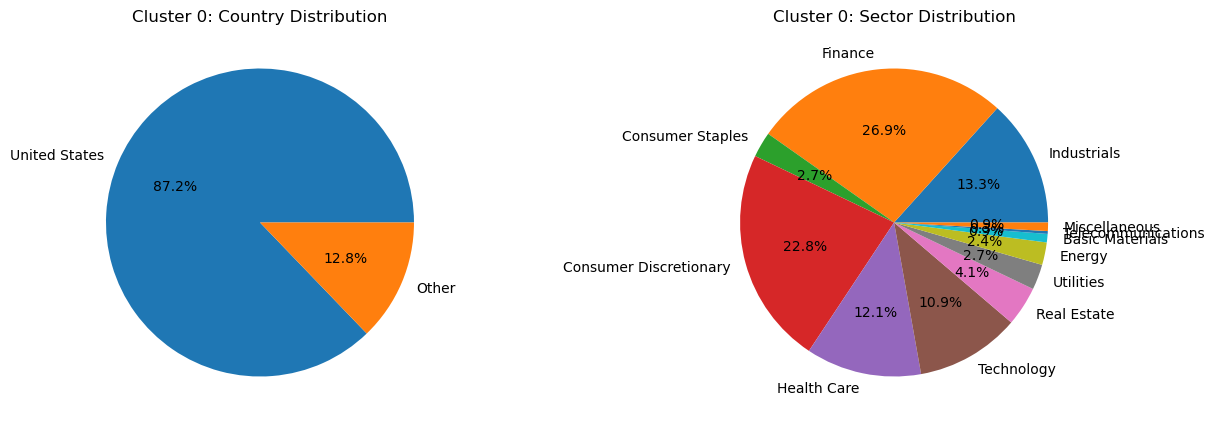

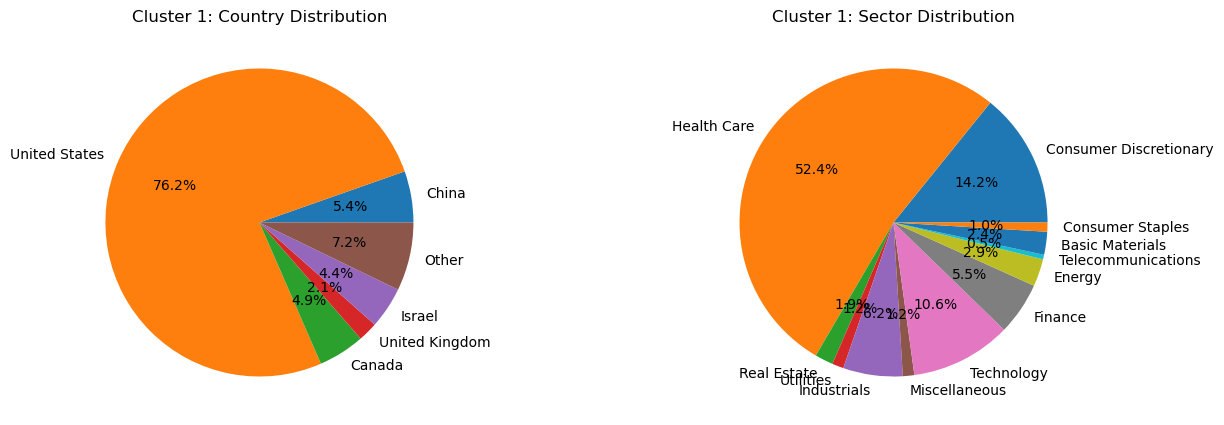

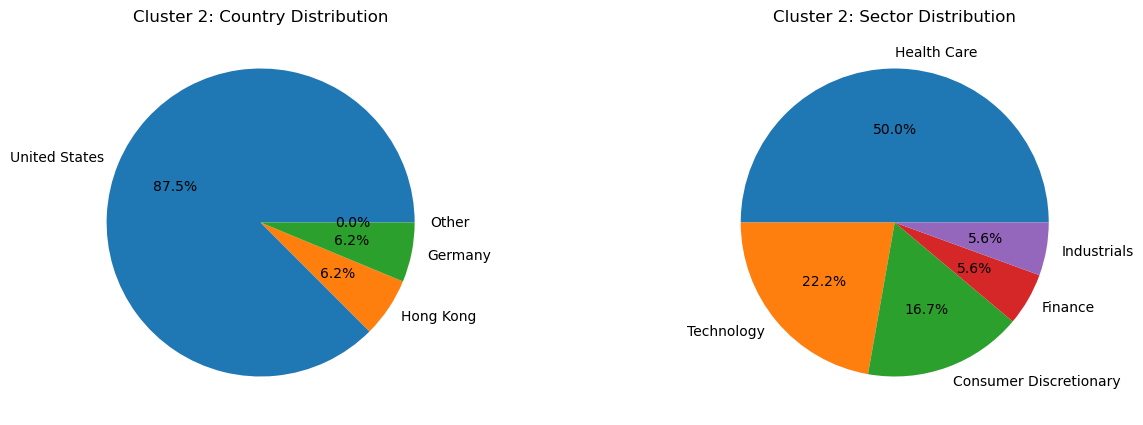

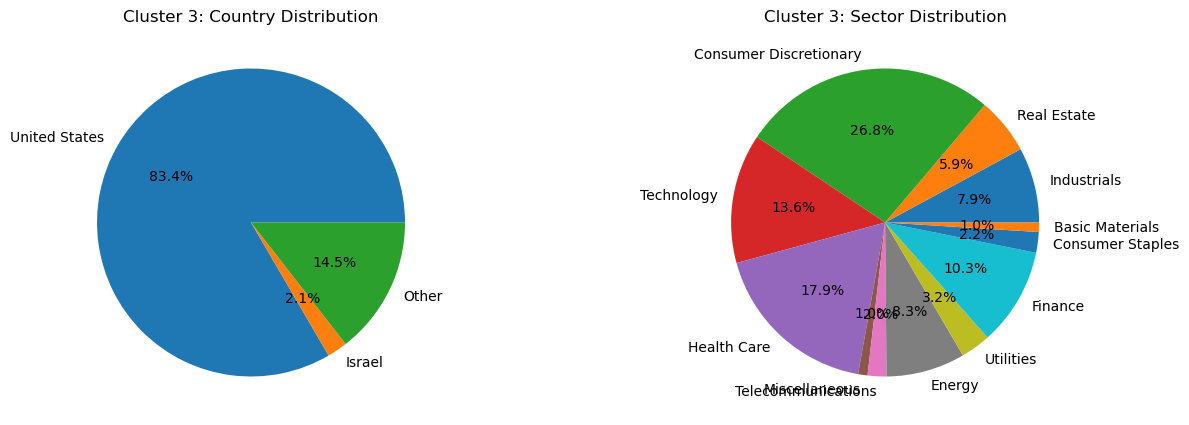

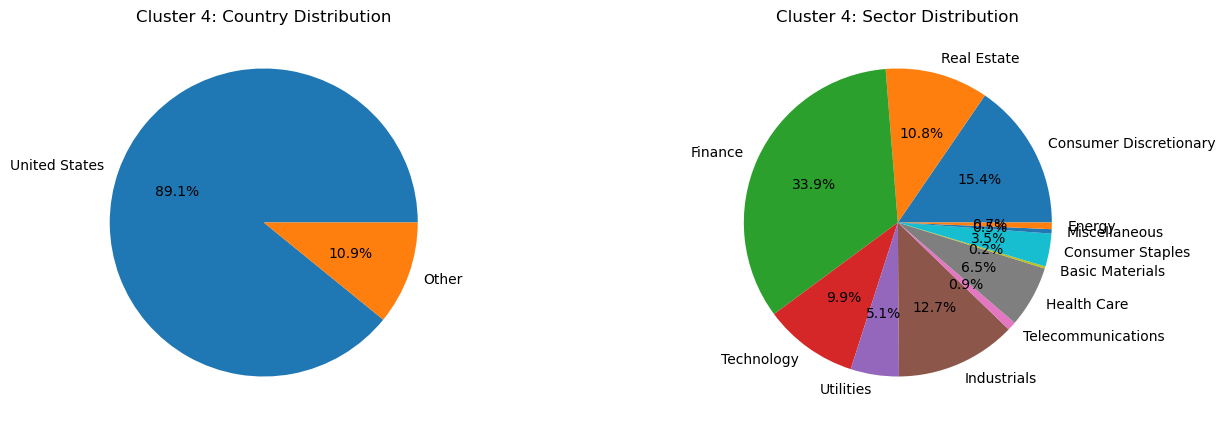

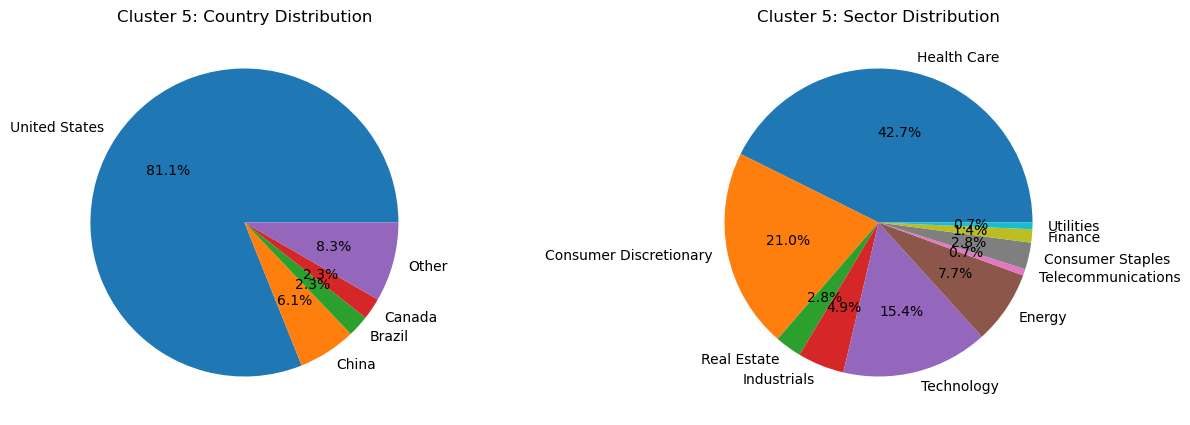

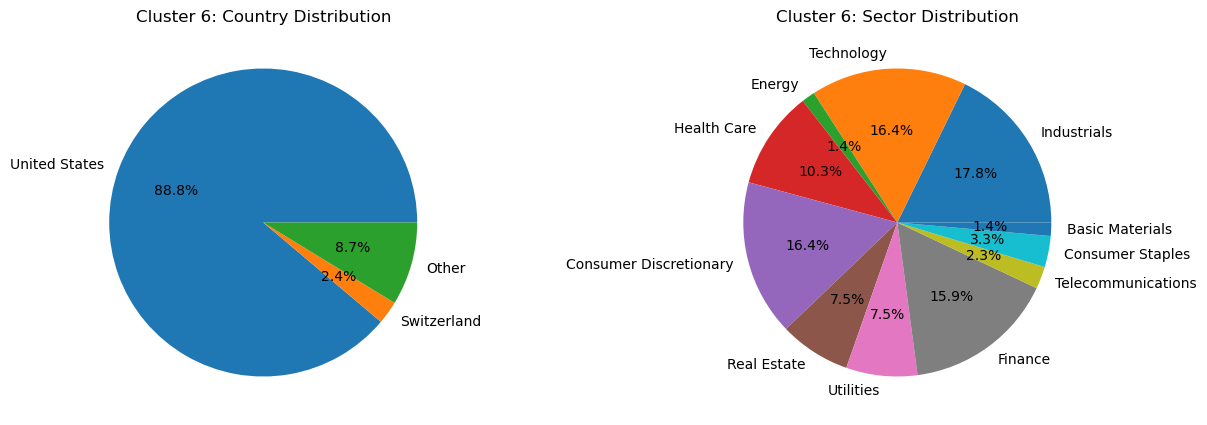

In [9]:
country_dict = {}
sector_dict = {}
industry_dict = {}
# Iterate through each row in the DataFrame
for idx, row in df3.iterrows():
    clus = clusters[idx]
    country = row['Country']
    sector = row['Sector']
    industry = row['Industry']
    # print(f"{country} {type(country)} {sector} {type(sector)} {industry} {type(industry)}")
    
    # Update the dictionaries with the counts of each category in each cluster
    if type(country) == type(''):
        country_dict[clus] = country_dict.get(clus, {})
        country_dict[clus][country] = country_dict[clus].get(country, 0) + 1
        
    if type(sector) == type(''):
        sector_dict[clus] = sector_dict.get(clus, {})
        sector_dict[clus][sector] = sector_dict[clus].get(sector, 0) + 1
    
    industry_dict[clus] = industry_dict.get(clus, {})
    industry_dict[clus][industry] = industry_dict[clus].get(industry, 0) + 1

    
for i in range(len(country_dict)):
    other = 0
    to_del = []
    for key in country_dict[i].keys():
        if country_dict[i][key] <= sum(country_dict[i].values()) * .02:
            other += country_dict[i][key]
            to_del.append(key)
    for d in to_del:
        del country_dict[i][d]
    country_dict[i]['Other'] = other
    
# Iterate through each cluster and create pie charts for each category
for i in range(len(set(clusters))):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create pie chart for countries
    country_counts = country_dict[i]
    country_labels = [country for country, count in country_counts.items()]
    country_counts = [count for count in country_counts.values()]
    ax[0].pie(country_counts, labels=country_labels, autopct='%1.1f%%')
    ax[0].set_title(f"Cluster {i}: Country Distribution")
    # Create pie chart for sectors
    sector_counts = sector_dict[i]
    sector_labels = [sector for sector, count in sector_counts.items()]
    sector_counts = [count for count in sector_counts.values()]
    ax[1].pie(sector_counts, labels=sector_labels, autopct='%1.1f%%')
    ax[1].set_title(f"Cluster {i}: Sector Distribution")

    
    # Add legend to the right side of the chart
    plt.show()

In [30]:
for i in range(len(set(clusters_arr[6]))):
    print(f"cluster {i}")
    print(country_dict[i])
    print(sector_dict[i])
clusters = clusters_arr[6]
sum_mkt = [0 for i in range(len(set(clusters)))] 
count = np.array([list(clusters).count(i) for i in range(len(set(clusters)))])
for idx, row in df3.iterrows():
    sum_mkt[clusters[idx]] += row['Market Cap']
sum_mkt = np.array(sum_mkt)
print(count)
print((sum_mkt / count) / (10 ** 9),2)


cluster 0
{'United States': 279, 'Other': 41}
{'Industrials': 45, 'Finance': 91, 'Consumer Staples': 9, 'Consumer Discretionary': 77, 'Health Care': 41, 'Technology': 37, 'Real Estate': 14, 'Utilities': 9, 'Energy': 8, 'Basic Materials': 3, 'Telecommunications': 1, 'Miscellaneous': 3}
cluster 1
{'China': 21, 'United States': 297, 'Canada': 19, 'United Kingdom': 8, 'Israel': 17, 'Other': 28}
{'Consumer Discretionary': 59, 'Health Care': 218, 'Real Estate': 8, 'Utilities': 5, 'Industrials': 26, 'Miscellaneous': 5, 'Technology': 44, 'Finance': 23, 'Energy': 12, 'Telecommunications': 2, 'Basic Materials': 10, 'Consumer Staples': 4}
cluster 2
{'United States': 14, 'Hong Kong': 1, 'Germany': 1, 'Other': 0}
{'Health Care': 9, 'Technology': 4, 'Consumer Discretionary': 3, 'Finance': 1, 'Industrials': 1}
cluster 3
{'United States': 392, 'Israel': 10, 'Other': 68}
{'Industrials': 40, 'Real Estate': 30, 'Consumer Discretionary': 136, 'Technology': 69, 'Health Care': 91, 'Miscellaneous': 5, 'Telec

In [31]:
companies = [set() for _ in range(len(set(clusters)))]
for idx, row in df3.iterrows():
    if row['Market Cap'] >= 10 ** 10:
        companies[clusters[idx]].add(row['Name'])
print("Cluster 0")
print(companies[0])
print('------------------------------------')
print("Cluster 1")
print(companies[1])
print('------------------------------------')
print("Cluster 2")
print(companies[2])
# Contains 
print('------------------------------------')
print("Cluster 3")
print(companies[3])
print('------------------------------------')
print("Cluster 4")
print(companies[4])
print('------------------------------------')
print("Cluster 5")
print(companies[5])
print('------------------------------------')
print("Cluster 6")
print(companies[6])

Cluster 0
{'Aspen Technology Inc. Common Stock', 'Ambev S.A. American Depositary Shares (Each representing 1 Common Share)', 'Builders FirstSource Inc. Common Stock', 'Dollar Tree Inc. Common Stock', 'ONEOK Inc. Common Stock', 'Match Group Inc. Common Stock', 'Avantor Inc. Common Stock', 'Howmet Aerospace Inc. Common Stock', 'BP p.l.c. Common Stock', 'Banco Santander Brasil SA American Depositary Shares each representing one unit', 'CF Industries Holdings Inc. Common Stock', 'Albemarle Corporation Common Stock', 'Deutsche Bank AG Common Stock', 'Illumina Inc. Common Stock', 'Advanced Micro Devices Inc. Common Stock', 'BioMarin Pharmaceutical Inc. Common Stock', 'Churchill Downs Incorporated Common Stock', 'ConocoPhillips Common Stock', 'Horizon Therapeutics Public Limited Company Ordinary Shares', 'Credicorp Ltd. Common Stock', 'Boeing Company (The) Common Stock', 'Energy Transfer LP Common Units ', 'Itau Unibanco Banco Holding SA American Depositary Shares (Each repstg 500 Preferred s

In [32]:
print("Cluster 0 contains Burlington, Boeing, Hyatt Hotels, and Expedia.")
print("Cluster 1 contains no companies I recognize.")
print("Cluster 2 contains Pinterest.")
print("Cluster 3 contains Datadog, Alibaba, Etsy, and Kroger.")
print("Cluster 4 contains GM, EA, PayPal, NVIDIA, and Blackstone.")
print("Cluster 5 contains no companies I recognize.")
print("Cluster 6 contains 3M, CVS, Alphabet, IBM, Microsoft, Amazon, Golcman Sachs, Morgan Stanley, and Cisco.")

Cluster 0 contains Burlington, Boeing, Hyatt Hotels, and Expedia.
Cluster 1 contains no companies I recognize.
Cluster 2 contains Pinterest.
Cluster 3 contains Datadog, Alibaba, Etsy, and Kroger.
Cluster 4 contains GM, EA, PayPal, NVIDIA, and Blackstone.
Cluster 5 contains no companies I recognize.
Cluster 6 contains 3M, CVS, Alphabet, IBM, Microsoft, Amazon, Golcman Sachs, Morgan Stanley, and Cisco.


In [33]:
def GMM(dat, k):
    np.random.seed(123)    
    # Define the variables we will use in the Algorithm
    # This represents W_m (weights/likelihood of each component) 
    p_class=np.zeros(k)
    
    # This represents μ_m (mean values of each component) 
    means=np.zeros((k,7))
    
    # This represents Σ_m (covariance matrix) 
    covars=np.zeros((k,7,7))
    
    # This represets p̃_mi 
    p_data_given_class=np.zeros((len(dat),k))

    # This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    # initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    """Initialize means, covs, p_classes"""
    # Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        # Set the cov matrix of each component to the cov of the entire dataset 
        covars[dim,:,:]=np.cov(np.transpose(dat))

        # Set initial means to initial chosen data points 
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        # Give each component equal weighting / likelihood to start 
        p_class[dim]=1/k
        
    
    # Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        
        ######################
        ## Expectation step ##
        ######################
        # Bayes stuff: pdfs then pdf*mixtures, then normalize
        
        #For each class (component), compute prob data given class 
        for dim in range(k):
            # Use pdf to get prob of each data point given component (dim) 
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim,:], cov=covars[dim,:,:], allow_singular=True)])
            # What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        # Multiply by p_class 
        p_class_given_data=p_data_given_class*p_class

        # Now consolidate into probabilities using 1/α_i 
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities 
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
            
        #######################
        ## Maximization step ##
        #######################
        
        #We'll count the number of points in each component (will be fractional, not whole #)
        #n_class represents n̂_m 
        n_class = np.sum(p_class_given_data, axis=0)

        #Now, we re-compute p_class 
        p_class=n_class/len(dat)

        #Now we need to do the mean and covariance updates 
        for dim in range(k):
            #To compute new means within each class/component 
            #1. Sum across: (p_class_given_data * data) = (p̂_mi * x_i)
            #2. Divide by n_class (n̂_m)
            means[dim,0]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,0])*(1/n_class[dim])
            means[dim,1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,1])*(1/n_class[dim])
            
            
            #Now we update the variance/covariance Σ_m by weighted sample covariance 
            
            # Make a copy of the data, then subtract the new means
            X_new=dat.copy()
            X_new.iloc[:,0]=X_new.iloc[:,0]-means[dim,0]
            X_new.iloc[:,1]=X_new.iloc[:,1]-means[dim,1]
                        
            # Compute the covar matrix for each component as below
            covars[dim,:,:]=np.matmul((np.asarray(X_new).T)*(p_class_given_data[:,dim]),X_new)/(n_class[dim])                                           
    
    #Once we're done with our for loop, we compute the mean dist:
    mean_dist=0
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
    mean_dist=mean_dist/(len(dat)*k)

    return p_class_given_data, means, covars, p_class, mean_dist

In [34]:
pmi_lst = []
mu_lst = []
sig_lst = []
p_lst = []
d_lst = []
# df_num.drop('roe', axis=1, inplace=True)
# Change remaining numbers to 0 since only dividend yield has NaNs remaining. This will still yield interesting information, since a lack of dividend yield means that company doesn't pay dividends and thus has a yield of 0.
df_num.fillna(0, inplace=True)
for i in range(1,8):
    print(i)
    pmi, mu, sig, p, d = GMM(df_num,i)
    pmi_lst.append(pmi)
    mu_lst.append(mu)
    sig_lst.append(sig)
    p_lst.append(p)
    d_lst.append(d)

1
2
3
4
5
6
7


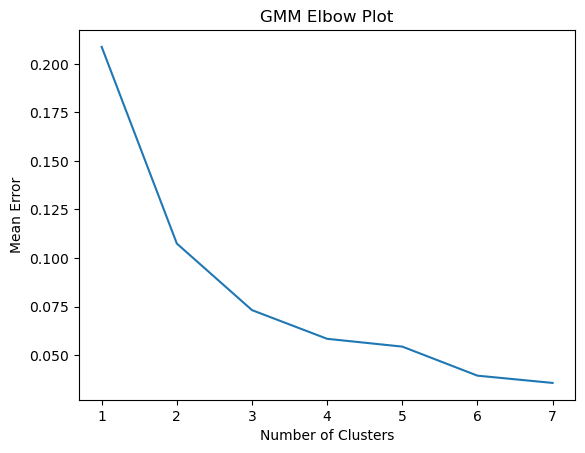

In [35]:
plt.title('GMM Elbow Plot')
plt.ylabel('Mean Error')
plt.xlabel('Number of Clusters')
plt.plot([i for i in range(1,1+len(d_lst))], d_lst)

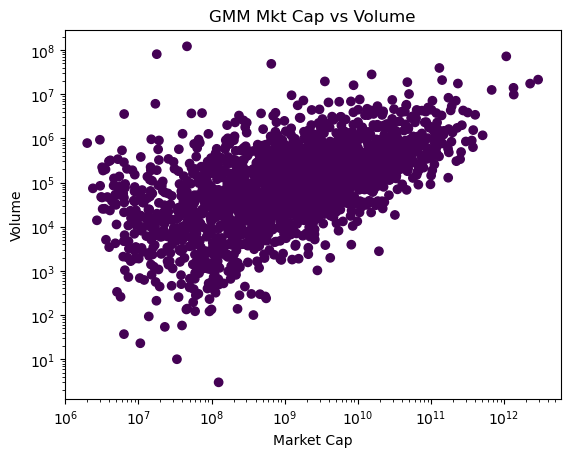

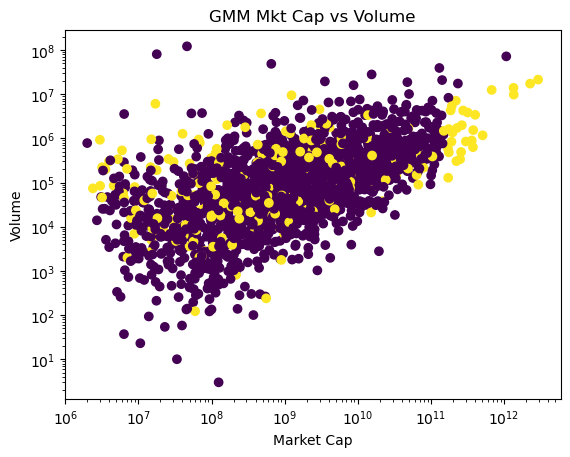

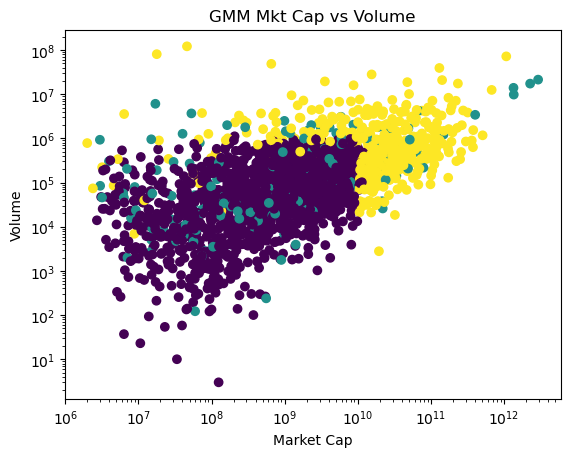

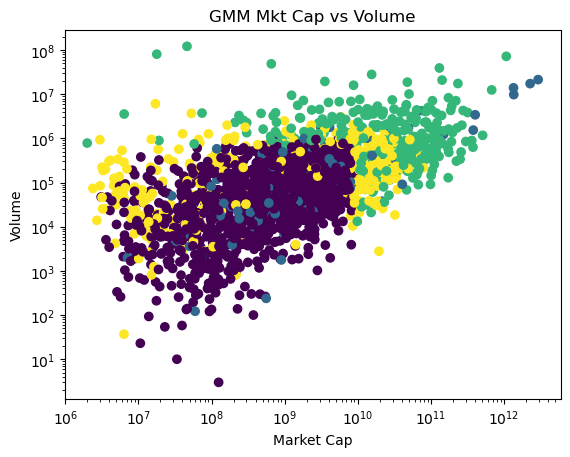

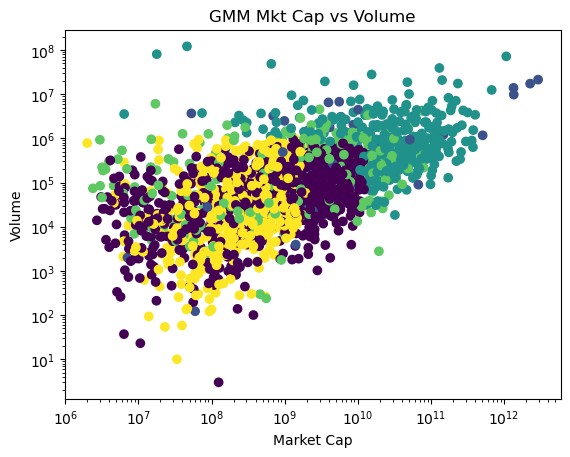

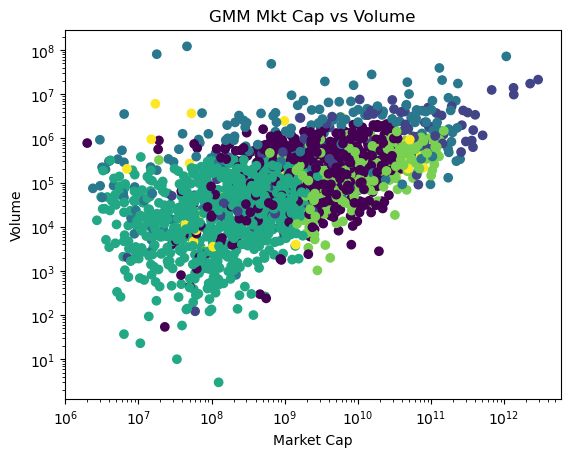

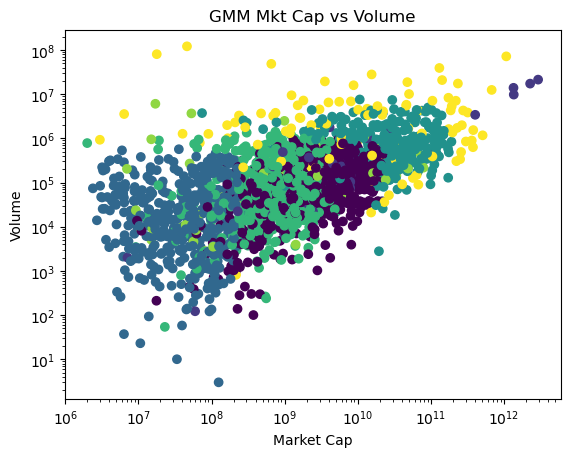

In [47]:
clust_assign = []
for pm in pmi_lst:
    clust_assign.append(np.argmax(pm, axis=1))

for i in range(len(clust_assign)):
    plt.figure()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('Market Cap')
    plt.ylabel('Volume')
    plt.title('GMM Mkt Cap vs Volume')
    plt.scatter(df3['Market Cap'], df3['Volume'], c=clust_assign[i])
    plt.plot()

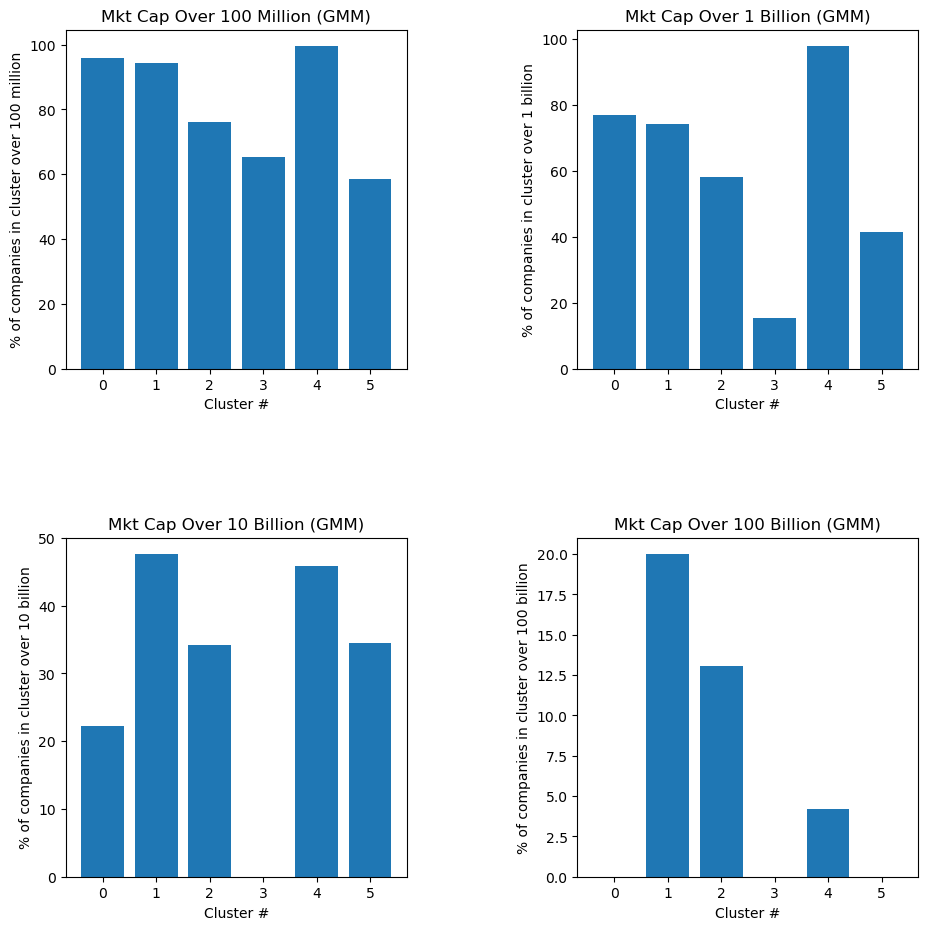

In [46]:
clust_gmm = clust_assign[5]
over_100_mil = [0] * len(set(clust_gmm)) # 10 ** 8
over_1_bil = [0] * len(set(clust_gmm))   # 10 ** 9
over_10_bil = [0] * len(set(clust_gmm))  # 10 ** 10
over_100_bil = [0] * len(set(clust_gmm)) # 10 ** 11
num_each_clust = [0] * len(set(clust_gmm))
for idx, row in df3.iterrows():
    num_each_clust[clust_gmm[idx]] += 1
    if row['Market Cap'] > 10 ** 8:
        over_100_mil[clust_gmm[idx]] += 1
    if row['Market Cap'] > 10 ** 9:
        over_1_bil[clust_gmm[idx]] += 1
    if row['Market Cap'] > 10 ** 10:
        over_10_bil[clust_gmm[idx]] += 1
    if row['Market Cap'] > 10 ** 11:
        over_100_bil[clust_gmm[idx]] += 1
over_100_mil_percent = (np.array(over_100_mil) / np.array(num_each_clust)) * 100
over_1_bil_percent = (np.array(over_1_bil) / np.array(num_each_clust)) * 100
over_10_bil_percent = (np.array(over_10_bil) / np.array(num_each_clust)) * 100
over_100_bil_percent = (np.array(over_100_bil) / np.array(num_each_clust)) * 100
for i in range(len(set(clust_gmm))):
    #print(f"In cluster {i}, {int(over_100_mil_percent[i])}% of companies had a mkt cap over 100 million, {int(over_1_bil_percent[i])}% of companies had a mkt cap over 1 billion, {int(over_10_bil_percent[i])}% of companies had a mkt cap over 10 billion, {int(over_100_bil_percent[i])}% of companies had a mkt cap over 100 billion")
    pass

# Define the labels for the x-axis
labels = [i for i in range(len(set(clust_gmm)))]

# Create a figure and four subplots
fig, axes = plt.subplots(2, 2,  figsize=(11, 11))

# Plot each list as a bar graph on a subplot
axes[0, 0].bar(labels, over_100_mil_percent)
axes[0, 1].bar(labels, over_1_bil_percent)
axes[1, 0].bar(labels, over_10_bil_percent)
axes[1, 1].bar(labels, over_100_bil_percent)

# Add axis labels and titles to each subplot
axes[0, 0].set_ylabel("% of companies in cluster over 100 million")
axes[0, 0].set_xlabel("Cluster #")
axes[0, 0].set_title("Mkt Cap Over 100 Million (GMM)")

axes[0, 1].set_ylabel("% of companies in cluster over 1 billion")
axes[0, 1].set_xlabel("Cluster #")
axes[0, 1].set_title("Mkt Cap Over 1 Billion (GMM)")

axes[1, 0].set_ylabel("% of companies in cluster over 10 billion")
axes[1, 0].set_xlabel("Cluster #")
axes[1, 0].set_title("Mkt Cap Over 10 Billion (GMM)")

axes[1, 1].set_ylabel("% of companies in cluster over 100 billion")
axes[1, 1].set_xlabel("Cluster #")
axes[1, 1].set_title("Mkt Cap Over 100 Billion (GMM)")

fig.subplots_adjust(wspace=0.5, hspace=0.5)


# Show the plot
plt.show()

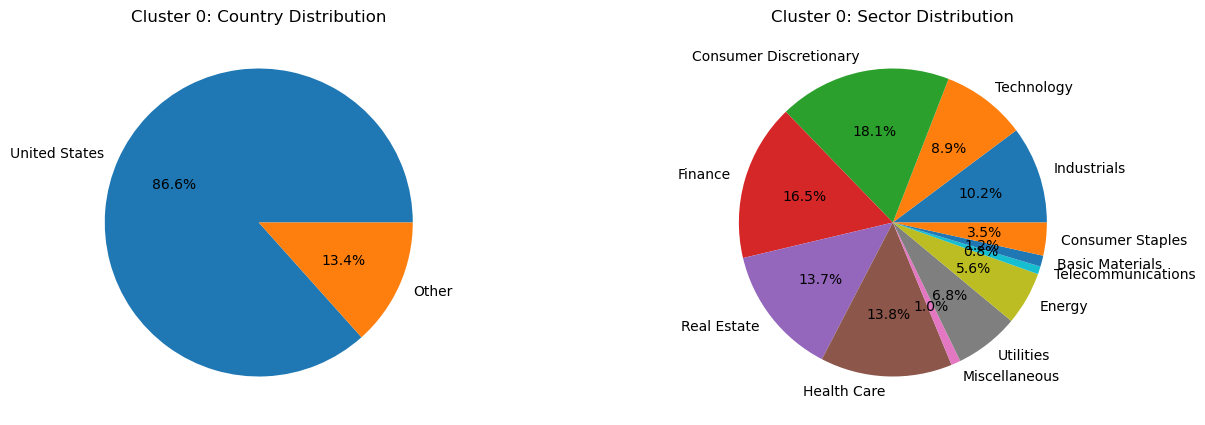

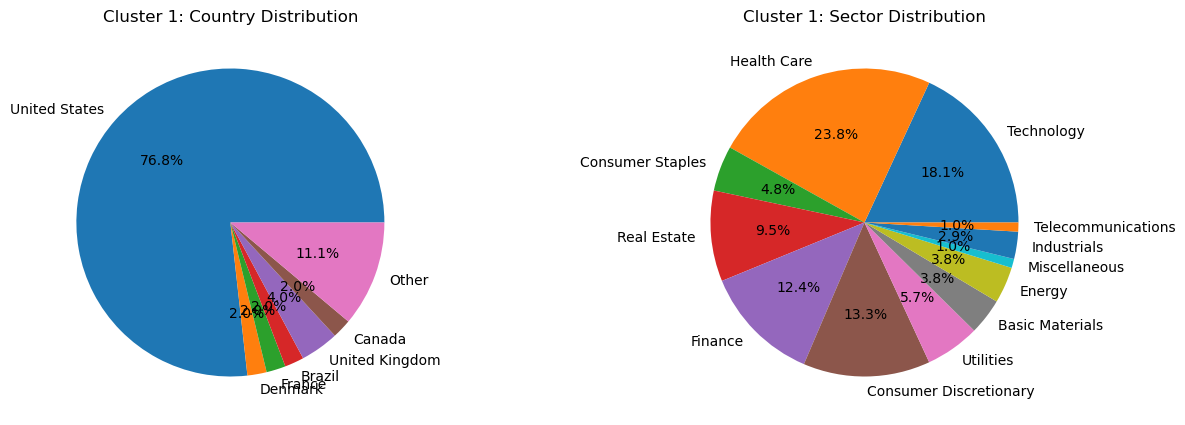

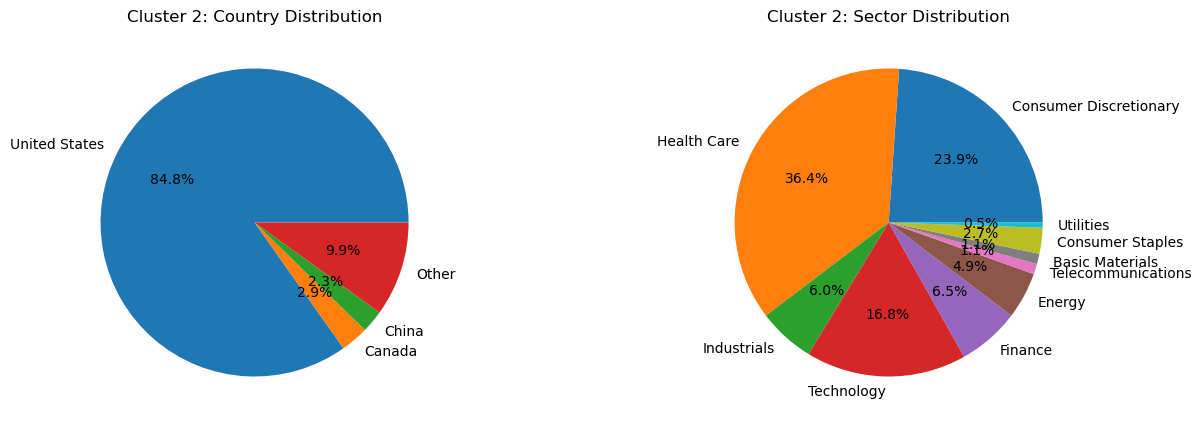

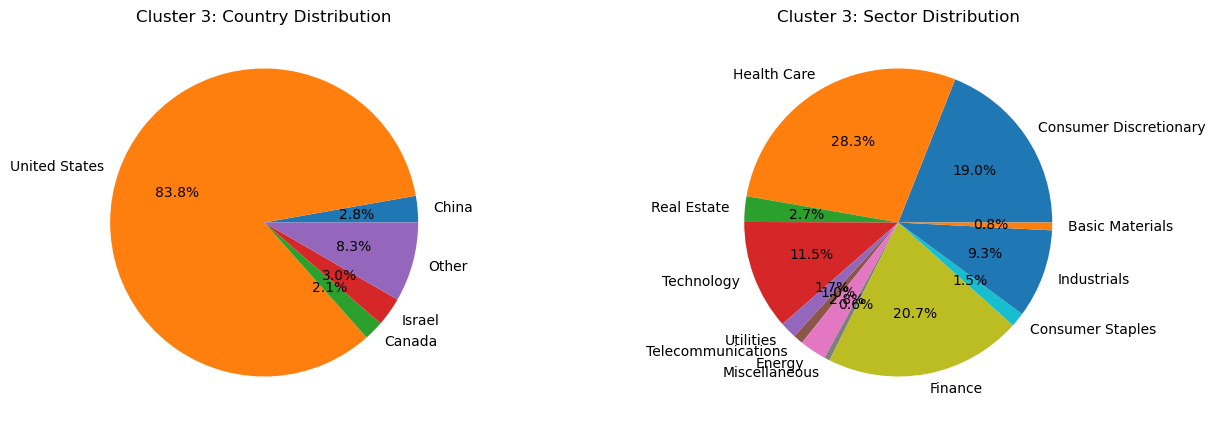

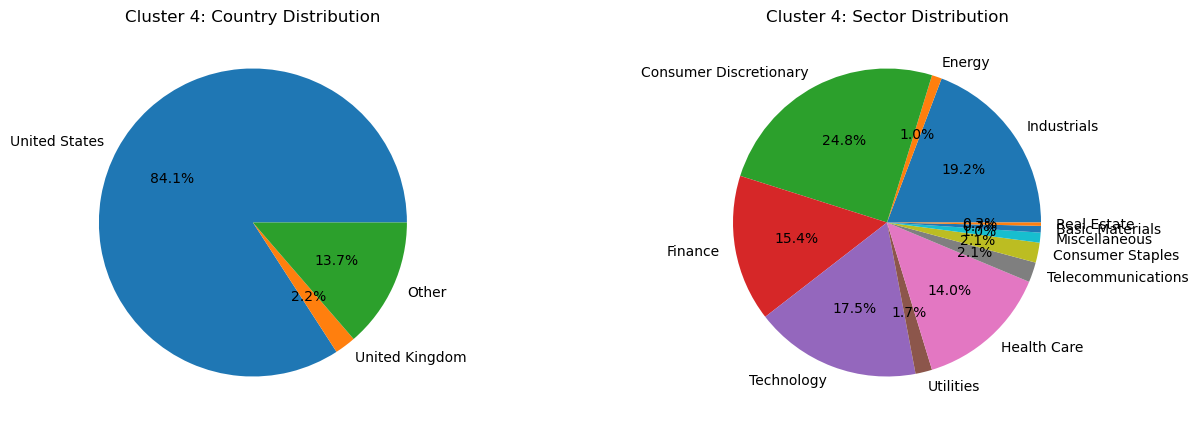

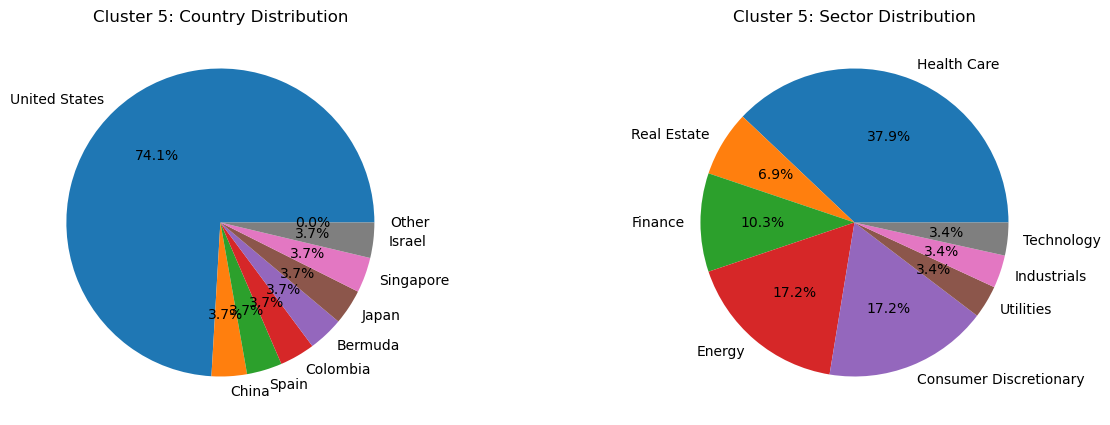

In [38]:
# Code borrowed from above
country_dict = {}
sector_dict = {}
industry_dict = {}
# Iterate through each row in the DataFrame
for idx, row in df3.iterrows():
    clus = clust_gmm[idx]
    country = row['Country']
    sector = row['Sector']
    industry = row['Industry']
    # print(f"{country} {type(country)} {sector} {type(sector)} {industry} {type(industry)}")
    
    # Update the dictionaries with the counts of each category in each cluster
    if type(country) == type(''):
        country_dict[clus] = country_dict.get(clus, {})
        country_dict[clus][country] = country_dict[clus].get(country, 0) + 1
        
    if type(sector) == type(''):
        sector_dict[clus] = sector_dict.get(clus, {})
        sector_dict[clus][sector] = sector_dict[clus].get(sector, 0) + 1
    
    industry_dict[clus] = industry_dict.get(clus, {})
    industry_dict[clus][industry] = industry_dict[clus].get(industry, 0) + 1

    
for i in range(len(country_dict)):
    other = 0
    to_del = []
    for key in country_dict[i].keys():
        if country_dict[i][key] <= sum(country_dict[i].values()) * .02:
            other += country_dict[i][key]
            to_del.append(key)
    for d in to_del:
        del country_dict[i][d]
    country_dict[i]['Other'] = other
    
# Iterate through each cluster and create pie charts for each category
for i in range(len(set(clust_gmm))):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create pie chart for countries
    country_counts = country_dict[i]
    country_labels = [country for country, count in country_counts.items()]
    country_counts = [count for count in country_counts.values()]
    ax[0].pie(country_counts, labels=country_labels, autopct='%1.1f%%')
    ax[0].set_title(f"Cluster {i}: Country Distribution")
    # Create pie chart for sectors
    sector_counts = sector_dict[i]
    sector_labels = [sector for sector, count in sector_counts.items()]
    sector_counts = [count for count in sector_counts.values()]
    ax[1].pie(sector_counts, labels=sector_labels, autopct='%1.1f%%')
    ax[1].set_title(f"Cluster {i}: Sector Distribution")

    
    # Add legend to the right side of the chart
    plt.show()

In [1]:
for i in range(len(set(clust_gmm))):
    print(f"cluster {i}")
    print(f"Country distrubution: {country_dict[i]}")
    print(f"Sector distrubution: {sector_dict[i]}")
    print(f"Industry distribution {industry_dict[i]}")
sum_mkt = [0 for i in range(len(set(clust_gmm)))] 
count = np.array([list(clust_gmm).count(i) for i in range(len(set(clust_gmm)))])
for idx, row in df3.iterrows():
    sum_mkt[clust_gmm[idx]] += row['Market Cap']
sum_mkt = np.array(sum_mkt)
print(count)
print((sum_mkt / count) / (10 ** 9),2)

NameError: name 'clust_gmm' is not defined

In [40]:
companies = [set() for _ in range(len(set(clust_gmm)))]
for idx, row in df3.iterrows():
    if row['Market Cap'] >= (10 ** 9) * 5:
        companies[clust_gmm[idx]].add(row['Name'])
print("Cluster 0")
print(companies[0])
print('------------------------------------')
print("Cluster 1")
print(companies[1])
print('------------------------------------')
print("Cluster 2")
print(companies[2])
# Contains 
print('------------------------------------')
print("Cluster 3")
print(companies[3])
print('------------------------------------')
print("Cluster 4")
print(companies[4])
print('------------------------------------')
print("Cluster 5")
print(companies[5])

Cluster 0
{'Intra-Cellular Therapies Inc. Common Stock', 'Kroger Company (The) Common Stock', 'Equity Residential Common Shares of Beneficial Interest', 'Ceridian HCM Holding Inc. Common Stock', 'LKQ Corporation Common Stock', 'Coca-Cola Consolidated Inc. Common Stock', 'GameStop Corporation Common Stock', 'Mid-America Apartment Communities Inc. Common Stock', 'ONEOK Inc. Common Stock', 'eBay Inc. Common Stock', 'AEGON N.V. Common Stock', "BJ's Wholesale Club Holdings Inc. Common Stock", 'Hewlett Packard Enterprise Company Common Stock', 'Entergy Corporation Common Stock', 'Banco Santander - Chile ADS', 'HF Sinclair Corporation Common Stock', 'Fortis Inc. Common Shares', 'Albemarle Corporation Common Stock', 'Gaming and Leisure Properties Inc. Common Stock', 'Cullen/Frost Bankers Inc. Common Stock', 'Garmin Ltd. Common Stock (Switzerland)', 'Hasbro Inc. Common Stock', 'Banco Santander Mexico S.A. Institucion de Banca Multiple Grupo Financiero Santander Mexico', 'Magellan Midstream Part

In [42]:
print("Cluster 0 contains Kroger, Hasbro, and GameStop")
print("Cluster 1 contains Apple, Alphabet, and Citigroup")
print("Cluster 2 contains Salesforce, Amazon, and DraftKings")
print("Cluster 3 contains no companies I recognize")
print("Cluster 4 contains Chipotle, Hershey, and Expedia")
print("Cluster 5 contains Honda and Motorola")

Cluster 0 contains Kroger, Hasbro, and GameStop
Cluster 1 contains Apple, Alphabet, and Citigroup
Cluster 2 contains Salesforce, Amazon, and DraftKings
Cluster 3 contains no companies I recognize
Cluster 4 contains Chipotle, Hershey, and Expedia
Cluster 5 contains Honda and Motorola


In [51]:
df3.loc[df3['Symbol'] == 'AAPL']

,Symbol,Name,% Change,Market Cap,Country,Volume,Sector,Industry,beta,dy,pe,roe
9,AAPL,Apple Inc. Common Stock,0.059,2.921515e+12,United States,21396566,Technology,Computer Manufacturing,0.56061,0.0055,25.748102,1.47943
